In [152]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  
import seaborn as sns
import numpy as np
from Bio import SeqIO
from augur.utils import json_to_tree
from scipy import stats

## Accumulation of ACE2-binding vs. immune evasion mutations

In [153]:
# RBD and ACE2 contacts from https://www.nature.com/articles/s41586-020-2180-5
RBD_sites = [x for x in range(438, 507)]
ACE2_contacts = [417, 446, 449, 453, 455, 456, 475, 486, 487, 489, 493, 496, 498, 500, 501, 502, 505]

In [154]:
# for escape, taking all sites with escape score equal to or higher than 0.05
# did this by eye, should ask jesse a better way
# https://jbloomlab.github.io/SARS2-RBD-escape-calc/

escape_sites = [346, 365, 403, 405, 420, 439, 440, 441, 444, 445, 447, 449, 452, 453, 
                455, 456, 460, 462, 468, 475, 487, 489, 490, 498, 500, 501, 504, 505, 514]

# there are quite a few sites with ~0.048. if we take everything equal to or higher than 0.04
escape_sites_04 = escape_sites + [356, 357, 394, 417, 469, 472, 484, 499]

In [155]:
ACE2_nonescape = [x for x in ACE2_contacts if x not in escape_sites]
escape_nonACE2 = [x for x in escape_sites if x not in ACE2_contacts]

In [168]:
def count_mutation_accumulation_on_tips(tree_file):
    """
    For each tip in the tree, find the nonsynonymous mutations that 
    occur at any of the sites in the provided lists (RBD, ACE2-contacts and Ab escape)  
    which have accumulated between the root of the tree and the tip
    """
    
    
    #read in the tree
    with open(tree_file, 'r') as f:
        tree_json = json.load(f)

    #put tree in Bio.phylo format
    tree = json_to_tree(tree_json)
    
    #initiate dictionary to keep track of the date and number of accumulated mutations for each tip on the tree
    muts_over_time = []
    
    #get date of the root
    root_date = tree.root.node_attrs['num_date']['value']
    
    for node in tree.find_clades(terminal=True):
        path = tree.get_path(node)
        
        #count the number of amino acid mutations between root and tip for each category of mutations
        muts_in_spike = [x.branch_attrs['mutations']['S'] for x in path if 'S' in x.branch_attrs['mutations'].keys()]
        #look only at nonsynonymous mutations, not deletions
        muts_in_spike = [[y for y in x if '-' not in y] for x in muts_in_spike]
        #count the number of amino acid mutations elsewhere in the genome
        muts_elsewhere = [x.branch_attrs['mutations'][G] for x in path for G in x.branch_attrs['mutations'].keys() if G not in ['nuc', 'S']]
        #look only at nonsynonymous mutations, not deletions
        muts_elsewhere = [[y for y in x if '-' not in y] for x in muts_elsewhere]

        muts_in_s1 = [[y for y in x if 14<=int(y[1:-1])<=685] for x in muts_in_spike]
        s1_muts_count = sum([len(x) for x in muts_in_s1])

        rbd_muts_on_path = [[y for y in x if int(y[1:-1]) in RBD_sites] for x in muts_in_spike]
        rbd_muts_count = sum([len(x) for x in rbd_muts_on_path])

        ace2_muts_on_path = [[y for y in x if int(y[1:-1]) in ACE2_contacts] for x in muts_in_spike]
        ace2_muts_count = sum([len(x) for x in ace2_muts_on_path])
        
        ace2_nonescape_on_path = [[y for y in x if int(y[1:-1]) in ACE2_nonescape] for x in muts_in_spike]
        ace2_nonescape_count = sum([len(x) for x in ace2_nonescape_on_path])

        escape_muts_on_path = [[y for y in x if int(y[1:-1]) in escape_sites] for x in muts_in_spike]
        escape_muts_count = sum([len(x) for x in escape_muts_on_path])
        
        escape_nonace2_on_path = [[y for y in x if int(y[1:-1]) in escape_nonACE2] for x in muts_in_spike]
        escape_nonace2_count = sum([len(x) for x in escape_nonace2_on_path])
        
        elsewhere_count = sum([len(x) for x in muts_elsewhere])




        #get the date of this tip
        num_date = node.node_attrs['num_date']['value']
        #time between root and tip
        time = num_date - root_date
        
        muts_over_time.append({'virus':'sars2', 'tip': node.name, 
                                  'date': num_date, 'time_from_root': time, 
                               's1_muts': s1_muts_count, 'elsewhere_muts':elsewhere_count,
                               'rbd_muts': rbd_muts_count,
                                  'ace2_muts': ace2_muts_count, 'escape_muts': escape_muts_count, 
                               'ace2_nonescape_muts': ace2_nonescape_count, 'escape_nonace2_muts': escape_nonace2_count})
    
    df = pd.DataFrame(muts_over_time)
    
    return df    
        

In [169]:
tree_file = '../sars2/auspice/ncov_gisaid_global_all-time.json'
df = count_mutation_accumulation_on_tips(tree_file)

## Plot accumulation of mutations in the different 'regions' (all of RBD, or ACE2-contacts, or escape sites) over time

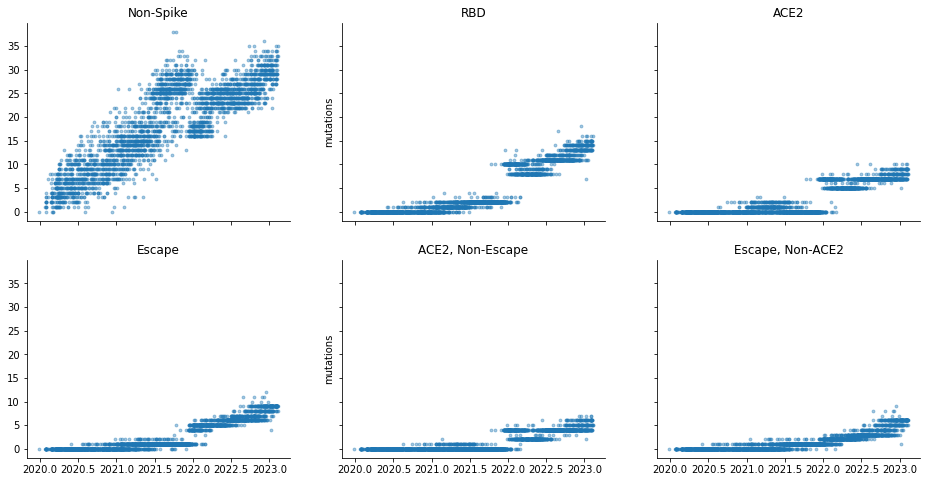

In [170]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(2,3, figsize=(16,8), sharey=True, sharex=True)

ax0.scatter(df['date'], df['elsewhere_muts'], 
             marker='o', alpha=0.4, s=8, zorder=1)
ax0.set_title('Non-Spike')

ax1.scatter(df['date'], df['rbd_muts'], 
             marker='o', alpha=0.4, s=8, zorder=1)
ax1.set_ylabel('mutations')
ax1.set_title('RBD')

ax2.scatter(df['date'], df['ace2_muts'], 
             marker='o', alpha=0.4, s=8, zorder=1)
ax2.set_title('ACE2')

ax3.scatter(df['date'], df['escape_muts'], 
             marker='o', alpha=0.4, s=8, zorder=1)
ax3.set_title('Escape')

ax4.scatter(df['date'], df['ace2_nonescape_muts'], 
             marker='o', alpha=0.4, s=8, zorder=1)
ax4.set_ylabel('mutations')
ax4.set_title('ACE2, Non-Escape')

ax5.scatter(df['date'], df['escape_nonace2_muts'], 
             marker='o', alpha=0.4, s=8, zorder=1)
ax5.set_title('Escape, Non-ACE2')

sns.despine()

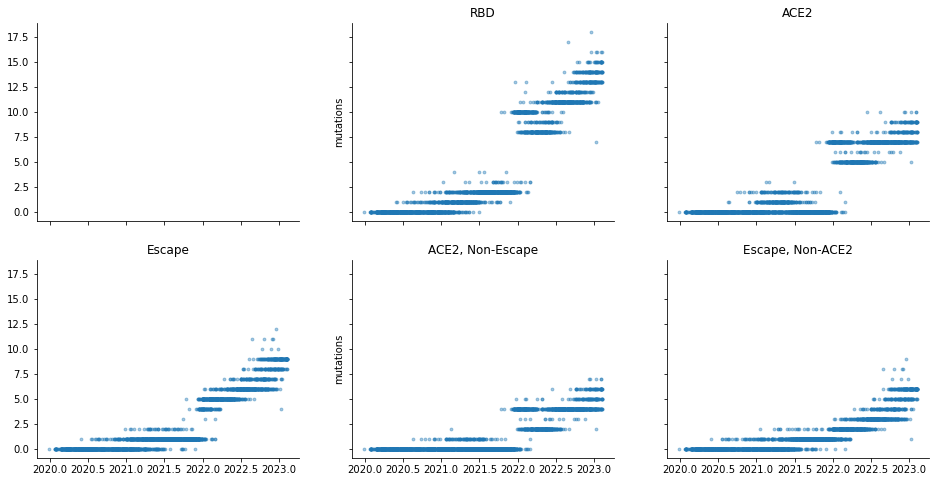

In [171]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(2,3, figsize=(16,8), sharey=True, sharex=True)

# ax0.scatter(df['date'], df['elsewhere_muts'], 
#              marker='o', alpha=0.4, s=8, zorder=1)
# ax0.set_title('Non-Spike')

ax1.scatter(df['date'], df['rbd_muts'], 
             marker='o', alpha=0.4, s=8, zorder=1)
ax1.set_ylabel('mutations')
ax1.set_title('RBD')

ax2.scatter(df['date'], df['ace2_muts'], 
             marker='o', alpha=0.4, s=8, zorder=1)
ax2.set_title('ACE2')

ax3.scatter(df['date'], df['escape_muts'], 
             marker='o', alpha=0.4, s=8, zorder=1)
ax3.set_title('Escape')

ax4.scatter(df['date'], df['ace2_nonescape_muts'], 
             marker='o', alpha=0.4, s=8, zorder=1)
ax4.set_ylabel('mutations')
ax4.set_title('ACE2, Non-Escape')

ax5.scatter(df['date'], df['escape_nonace2_muts'], 
             marker='o', alpha=0.4, s=8, zorder=1)
ax5.set_title('Escape, Non-ACE2')

sns.despine()

## Plot the slope of correlation between muts in these 'regions' and time, for discrete time windows

In [208]:
def plot_slope_over_time_with_mut_accumulation(period_length):
    """
    Plot the number of accumulated mutations within each site category
    Also, plot the slope of mutations over time, within given time periods of length `period_length`
    """
    # slope during different time periods
    # break pandemic into chunks of 6 months (list will be starting time)
    time_periods = np.arange(2020.0, 2023.0, period_length)

    # store slope for each type of mutation for each time period
    mut_types = ['rbd', 'ace2', 'escape']
    start_dates = []
    slope_by_period = {m:[] for m in mut_types}

    for t in time_periods:
        start_dates.append(t)
        for mut_type in mut_types:
            df_period = df[(df['date']>=t)& (df['date']<t+period_length)]

            #get linear fit
            coef = np.polyfit(df_period['date'], df_period[f'{mut_type}_muts'], 1)
            poly1d_fn = np.poly1d(coef)
            slope = coef[0]

            slope_by_period[mut_type].append(slope)
            
    #plot text styling
    sns.set_style("white")
    plt.rcParams['axes.labelsize'] = 16
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 10
    plt.rcParams['legend.fontsize'] = 10
    
    plt.rcParams['figure.dpi']= 300


    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(16,8), sharey='row', sharex=True)
    #plot mut accumulation
    ax1.scatter(df['date'], df['rbd_muts'], 
                 marker='o', alpha=0.4, s=8, zorder=1, color='#9F2A44')
    ax1.set_ylabel('AA Substitutions in Region')
    ax1.set_title('All RBD')
    
    ax2.scatter(df['date'], df['ace2_muts'], 
                 marker='o', alpha=0.4, s=8, zorder=1, color='#F5AD52')
    ax2.set_title('ACE2 Contacts')

    ax3.scatter(df['date'], df['escape_muts'], 
                 marker='o', alpha=0.4, s=8, zorder=1, color='#208288')
    ax3.set_title('Escape Sites')
    
    #plot slope over time
    
    ax4.scatter(start_dates, slope_by_period['rbd'], marker='o', color='#9F2A44')
    ax4.set_ylabel('Slope of Mutations vs Time\n(4 month time windows)')

    ax5.scatter(start_dates, slope_by_period['ace2'], marker='o', color='#F5AD52')

    ax6.scatter(start_dates, slope_by_period['escape'], marker='o', color='#208288')

    
    ax1.set_xticks([2020,2021,2022,2023])


    sns.despine()

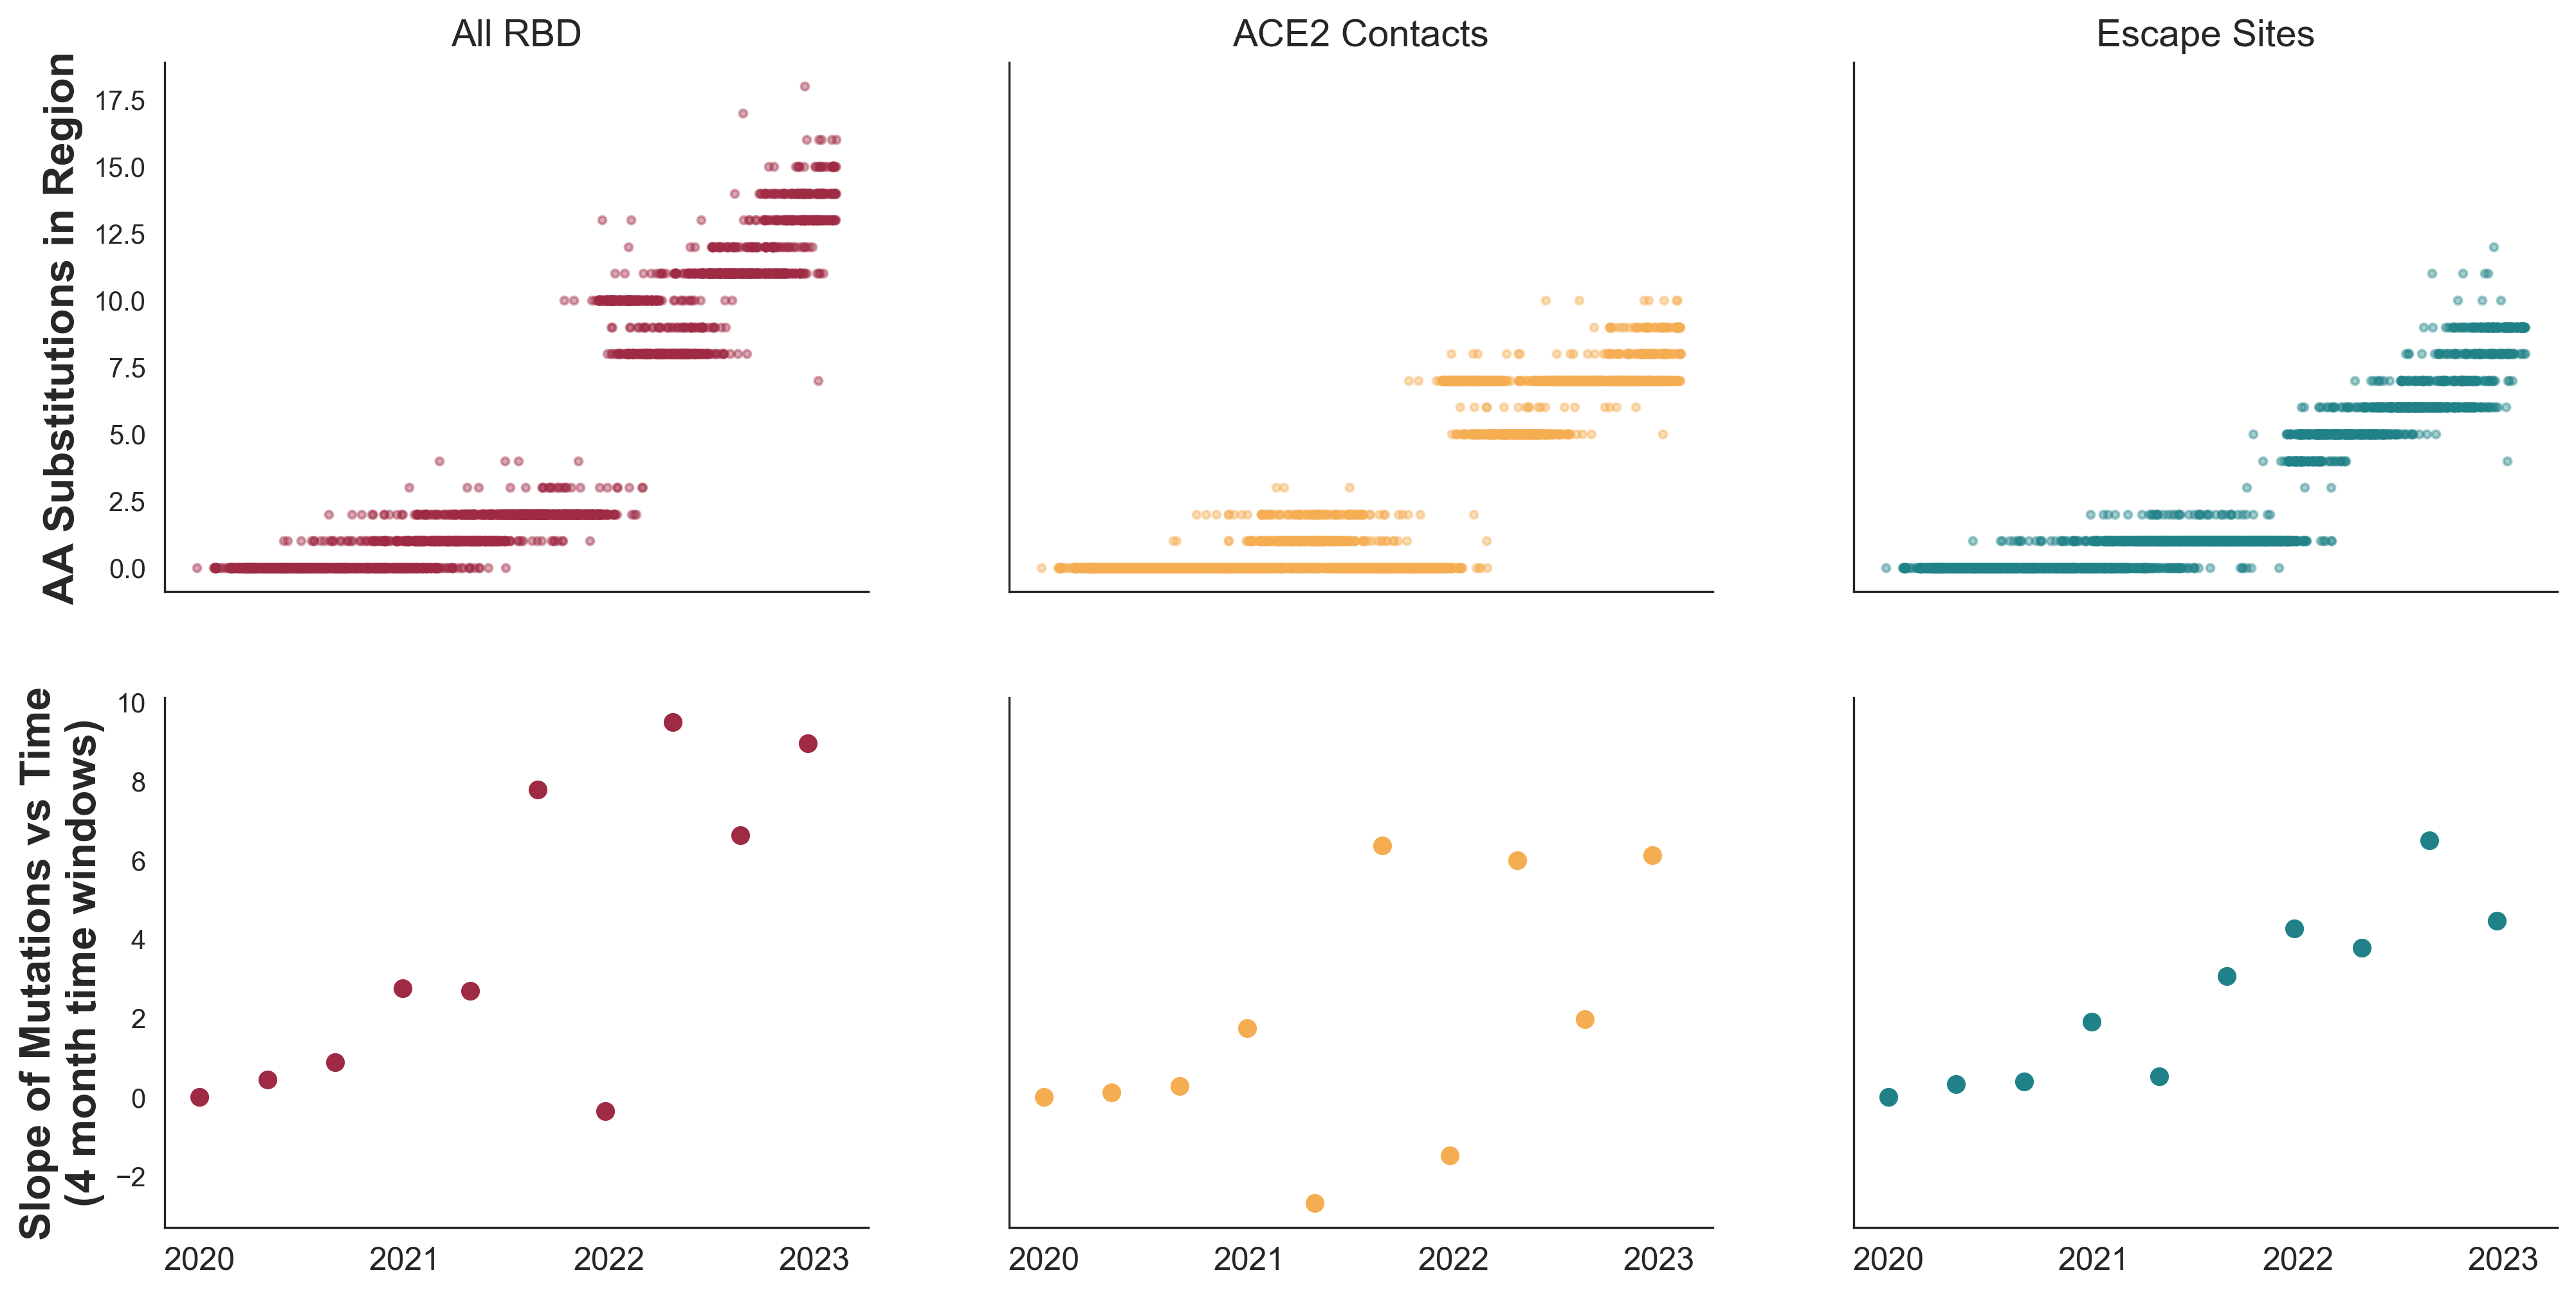

In [209]:
plot_slope_over_time_with_mut_accumulation(0.33)

In [120]:
def plot_slope_over_time(period_length):
    """
    Plot the slope of mutations over time, within given time periods of length `period_length`
    """
    # slope during different time periods
    # break pandemic into chunks of 6 months (list will be starting time)
    time_periods = np.arange(2020.0, 2023.0, period_length)

    # store slope for each type of mutation for each time period
    mut_types = ['rbd', 'ace2', 'escape']
    start_dates = []
    slope_by_period = {m:[] for m in mut_types}

    for t in time_periods:
        start_dates.append(t)
        for mut_type in mut_types:
            df_period = df[(df['date']>=t)& (df['date']<t+period_length)]

            #get linear fit
            coef = np.polyfit(df_period['date'], df_period[f'{mut_type}_muts'], 1)
            poly1d_fn = np.poly1d(coef)
            slope = coef[0]

            slope_by_period[mut_type].append(slope)


    # plot slope over time
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,4), sharey=True)

    ax1.scatter(start_dates, slope_by_period['rbd'], marker='o')
    ax1.set_title('RBD')
    ax1.set_ylabel('slope of mutations vs time')

    ax2.scatter(start_dates, slope_by_period['ace2'], marker='o')
    ax2.set_title('ACE2')

    ax3.scatter(start_dates, slope_by_period['escape'], marker='o')
    ax3.set_title('Escape')


    sns.despine()

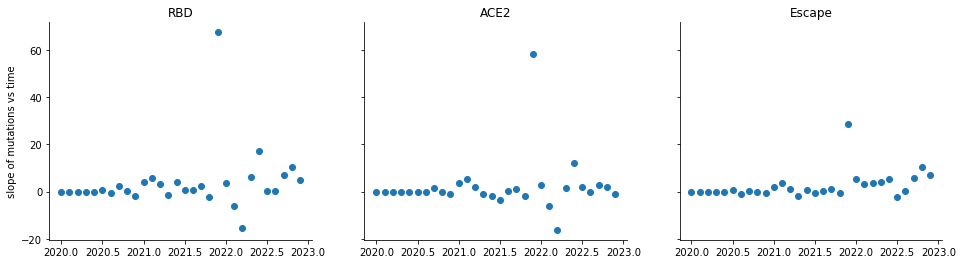

In [82]:
plot_slope_over_time(0.1)

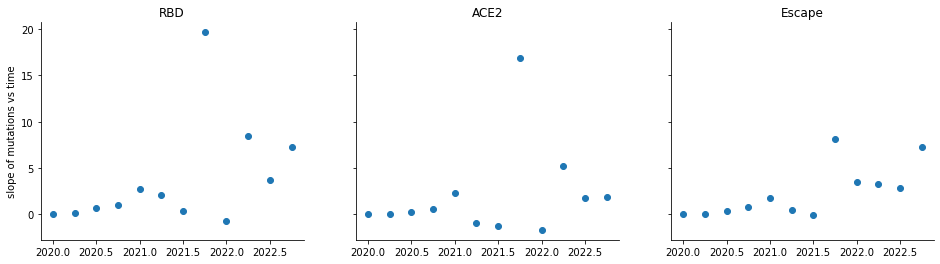

In [83]:
plot_slope_over_time(0.25)

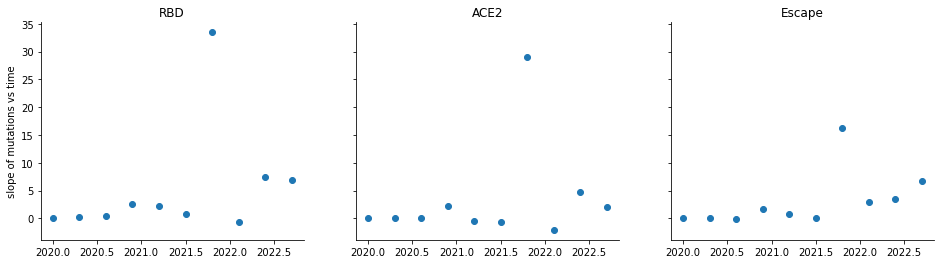

In [84]:
plot_slope_over_time(0.3)

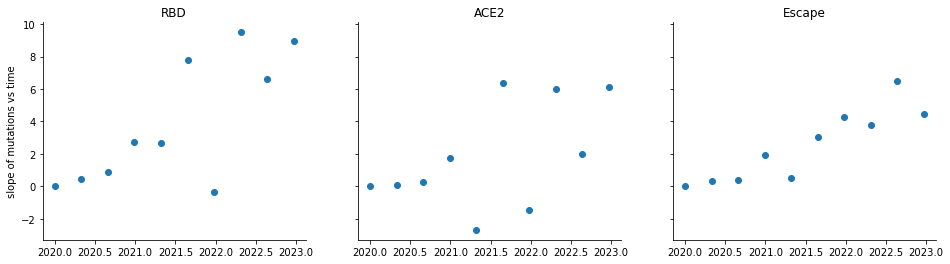

In [122]:
plot_slope_over_time(0.33)

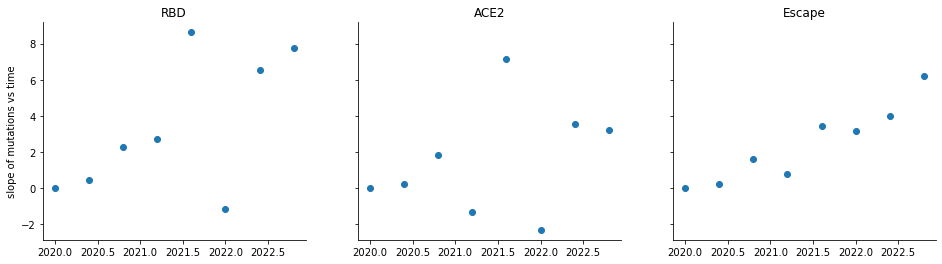

In [121]:
plot_slope_over_time(0.4)

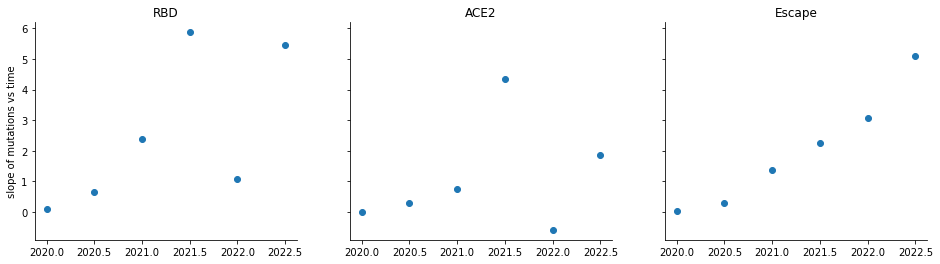

In [86]:
plot_slope_over_time(0.5)

In [148]:
# get time when avg number of mutations is X, for each type of mutation
# idea is to show that it takes longer for escape mutations to accumulation vs ace2

time_points = np.arange(2020.0, 2023.3, 0.1)

# store avg number of muts in category at certain date
mut_types = ['rbd', 'ace2', 'escape']
dates = []
muts_by_date = {m:[] for m in mut_types}

#look at avg number of muts in 0.1year chunks of time
#time listed is endpoint
for mut_type in mut_types:
    for t in time_points:
        df_before_date = df[(df['date']>t-0.1)& (df['date']<t)]
        dates.append(t)
        muts_by_date[mut_type].append(df_before_date[f'{mut_type}_muts'].mean())

# for each kind of mut, find date when population exceeds X number of this kind of muts
mut_counts = [1, 2,3,4,5,6,7,8]
# time_til_mut_count = {m:{} for m in mut_types}
time_til_mut_count = []

for m in mut_types:
    mut_means = muts_by_date[m]
    for x in mut_counts:
        for i in range(len(mut_means)):
            if mut_means[i] > x:
                time_til_mut_count.append({'category':m, 'count': x, 'date':dates[i]})
#                 time_til_mut_count[m][x] = dates[i]
                break
                
time_til_df = pd.DataFrame(time_til_mut_count)

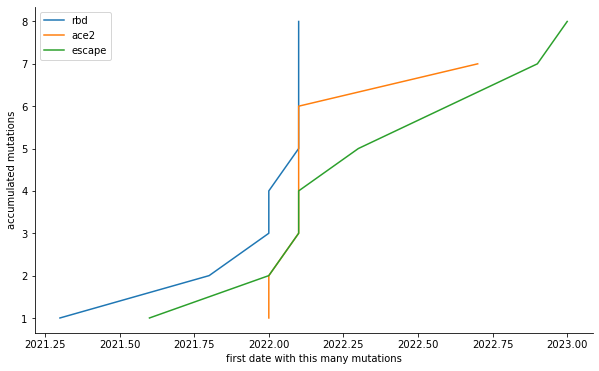

In [150]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_ylabel('accumulated mutations')
ax.set_xlabel('first date with this many mutations')

for x in ['rbd', 'ace2', 'escape']:
    subset = time_til_df[time_til_df['category']==x]
    ax = plt.plot(subset['date'], subset['count'], label=x)

plt.legend()

# ax = sns.lineplot(x='date', y='count', hue='category', data=time_til_df, ci=None)
sns.despine()